In [4]:
import torch
from transformer_lens import HookedTransformer
import numpy as np 
# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_sweep_tied_mlpout_l1_r8/_9/learned_dicts.pt"
# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_sweep_tied_mlpout_l2_r4/_19/learned_dicts.pt"
autoencoder_filename = "/mnt/ssd-cluster/longrun2408/tied_residual_l4_r6/_31/learned_dicts.pt"
auto_num = 5 # Selects which specific autoencoder to use
all_autoencoders = torch.load(autoencoder_filename)
num_dictionaries = len(all_autoencoders)
autoencoder, hyperparams = all_autoencoders[auto_num]
l1_alpha = hyperparams['l1_alpha']
autoencoder2, hyperparams2 = all_autoencoders[auto_num+1]
smaller_dict = autoencoder.get_learned_dict()
larger_dict = autoencoder2.get_learned_dict()

#Change these settings to load the correct autoencoder
layer = 4
setting = "residual"
# setting = "attention"
# setting = "mlp"
# setting = "mlp_out"
model_name = "EleutherAI/pythia-70m-deduped"
# model_name = "EleutherAI/pythia-160m"

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
elif setting == "attention":
    cache_name = f"blocks.{layer}.hook_attn_out"
    neurons = model.cfg.d_model
elif setting == "mlp_out":
    cache_name = f"blocks.{layer}.hook_mlp_out"
    neurons = model.cfg.d_model
else:
    raise NotImplementedError

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [5]:
hyperparams, hyperparams2

({'dict_size': 3072, 'l1_alpha': 0.0013894954463467002},
 {'dict_size': 3072, 'l1_alpha': 0.0026826958637684584})

# MCS
Max cosine similarity between one dictionary & another one. If they learned the same feature, then they'll have high cosine similarity. 

If two dictionaries learned it, it's probably a real feature.

('# of features above 0.9:', 1000)


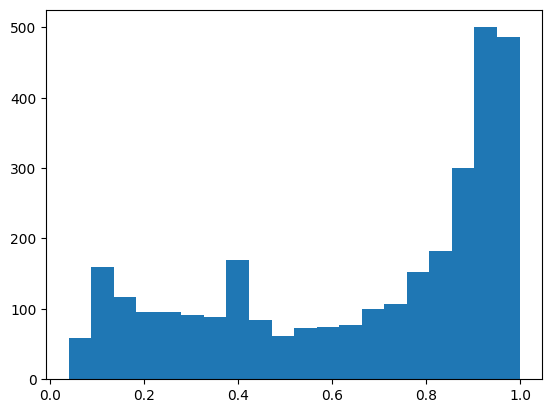

In [6]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
#Dictionary Comparison
smaller_dict_features, _ = smaller_dict.shape
larger_dict_features, _ = larger_dict.shape
larger_dict = larger_dict.to(device)
# Hungary algorithm
# Calculate all cosine similarities and store in a 2D array
cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
for idx, vector in enumerate(smaller_dict):
    cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
# Convert to a minimization problem
cos_sims = 1 - cos_sims
# Use the Hungarian algorithm to solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cos_sims)
# Retrieve the max cosine similarities and corresponding indices
max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]

# Get the indices of the max cosine similarities in descending order
max_indices = np.argsort(max_cosine_similarities)[::-1]
max_cosine_similarities[max_indices][:20]
print(("# of features above 0.9:", (max_cosine_similarities > .9).sum()))
# Plot histogram of max_cosine_similarities
plt.hist(max_cosine_similarities, bins=20)
plt.show()

# Model activations & Dictionary Activations

In [7]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
token_amount= 40
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

Map: 100%|██████████| 9862/9862 [00:04<00:00, 2099.83 examples/s]


In [8]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
# neurons = model.W_in.shape[-1]
neurons = model.cfg.d_model
datapoints = dataset.num_rows
batch_size = 32
neuron_activations = torch.zeros((datapoints*token_amount, neurons))
dictionary_activations = torch.zeros((datapoints*token_amount, smaller_dict_features))
smaller_auto_encoder = autoencoder
smaller_auto_encoder.to_device(device)

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(device))
        batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
        neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
        batched_dictionary_activations = smaller_auto_encoder.encode(batched_neuron_activations)
        dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()

100%|██████████| 309/309 [00:07<00:00, 43.56it/s]


In [7]:
dictionary_activations[:100000].count_nonzero(dim=1).float().mean()

tensor(71.2492)

# Feature Activation Analysis

## Useful Functions

In [9]:
from circuitsvis.activations import text_neuron_activations
# Get the activations for the best dict features
def get_feature_datapoints(feature_index, dictionary_activations, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(model.tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = model.tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list

def get_neuron_activation(token, feature, model, setting="dictionary_basis"):
    with torch.no_grad():
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        neuron_act_batch = cache[cache_name]
        if setting=="dictionary_basis":
            neuron_act_batch = rearrange(neuron_act_batch, "b s n -> (b s) n" )
            act = smaller_auto_encoder.encode(neuron_act_batch)
            return act[:, feature].tolist()
        else: # neuron/residual basis
            return neuron_act_batch[0, :, feature].tolist()

def ablate_text(text, feature, model, setting="dictionary_basis", return_activations=False):
    if isinstance(text, str):
        text = [text]
    display_text_list = []
    activation_list = []
    for t in text:
        # Convert text into tokens
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            tokens = model.to_tokens(t, prepend_bos=False)
        else: # t equals tokens
            tokens = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        seq_size = tokens.shape[1]
        if(seq_size == 1): # If the text is a single token, we can't ablate it
            continue
        original = get_neuron_activation(tokens, feature, model)[-1]
        changed_activations = torch.zeros(seq_size, device=device).cpu()
        for i in range(seq_size):
            # Remove the i'th token from the input
            ablated_tokens = torch.cat((tokens[:,:i], tokens[:,i+1:]), dim=1)
            changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model, setting)[-1]
        changed_activations -= original
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        activation_list += changed_activations.tolist() + [0.0]
    activation_list = torch.tensor(activation_list).reshape(-1,1,1)
    if return_activations:
        return activation_list, display_text_list
    else:
        return text_neuron_activations(tokens=display_text_list, activations=activation_list)

def visualize_text(text, feature, model, setting="dictionary_basis", max_activation = None, return_activations=False):
    if isinstance(text, str):
        text = [text]
    if isinstance(feature, int):
        feature = [feature]
    display_text_list = []
    act_list = []
    for t in text:
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            token = model.to_tokens(t, prepend_bos=False)
        else: # t are tokens
            token = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        for f in feature:
            display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            act_list += get_neuron_activation(token, f, model, setting) + [0.0]
    act_list = torch.tensor(act_list).reshape(-1,1,1)
    if(max_activation is not None):
        act_list = torch.clamp(act_list, max=max_activation)
    if return_activations:
        return act_list, display_text_list
    else:
        return text_neuron_activations(tokens=display_text_list, activations=act_list)
# Ablate the feature direction of the tokens
# token_list is a list of tokens, convert to tensor of shape (batch_size, seq_len)
from einops import rearrange
def ablate_feature_direction(tokens, feature, model, autoencoder):
    def mlp_ablation_hook(value, hook):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        act = autoencoder.encode(int_val)
        feature_to_ablate = feature # TODO: bring this out of the function

        # Subtract value with feature direction*act_of_feature
        dictionary_for_this_autoencoder = autoencoder.get_learned_dict()
        feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), dictionary_for_this_autoencoder[feature_to_ablate].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name, 
            mlp_ablation_hook
            )]
        )
def add_feature_direction(tokens, feature, model, autoencoder, scalar=1.0):
    def residual_add_hook(value, hook):
        feature_direction = autoencoder.decoder.weight[:, feature].squeeze()
        value += scalar*feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name,
            residual_add_hook
            )]
        )
def ablate_feature_direction_display(text, features=None, setting="true_tokens", verbose=False):

    if features==None:
        features = torch.tensor([best_feature])
    if isinstance(features, int):
        features = torch.tensor([features])
    if isinstance(features, list):
        features = torch.tensor(features)
    if isinstance(text, str):
        text = [text]
    text_list = []
    logit_list = []
    for t in text:
        tokens = model.to_tokens(t, prepend_bos=False)
        with torch.no_grad():
            original_logits = model(tokens).log_softmax(-1).cpu()
            ablated_logits = ablate_feature_direction(tokens, features, model, smaller_auto_encoder).log_softmax(-1).cpu()
        diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
        tokens = tokens.cpu()
        if setting == "true_tokens":
            split_text = model.to_str_tokens(t, prepend_bos=False)
            gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
            # Gather the logits for the true tokens
            diff = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
        elif setting == "max":
            # Negate the diff_logits to see which tokens have the largest effect on the neuron
            val, ind = (-1*diff_logits).max(-1)
            diff = rearrange(val[:, :-1], "b s -> (b s)")
            diff*= -1 # Negate the values gathered
            split_text = model.to_str_tokens(ind, prepend_bos=False)
            gather_tokens = rearrange(ind[:,1:], "1 s -> 1 s 1")
        split_text = split_text[1:] # Remove the first token since we're not predicting it
        if(verbose):
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            orig = rearrange(original_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            ablated = rearrange(ablated_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            logit_list += orig.tolist() + [0.0]
            logit_list += ablated.tolist() + [0.0]
        text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        logit_list += diff.tolist() + [0.0]
    logit_list = torch.tensor(logit_list).reshape(-1,1,1)
    if verbose:
        print(f"Max & Min logit-diff: {logit_list.max().item():.2f} & {logit_list.min().item():.2f}")
    return text_neuron_activations(tokens=text_list, activations=logit_list)
def generate_text(input_text, num_tokens, model, autoencoder, feature, temperature=0.7, setting="add", scalar=1.0):
    # Convert input text to tokens
    input_ids = model.tokenizer.encode(input_text, return_tensors='pt').to(device)

    for _ in range(num_tokens):
        # Generate logits
        with torch.no_grad():
            if(setting=="add"):
                logits = add_feature_direction(input_ids, feature, model, autoencoder, scalar=scalar)
            else:
                logits = model(input_ids)

        # Apply temperature
        logits = logits / temperature

        # Sample from the distribution
        probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)
        predicted_token = torch.multinomial(probs, num_samples=1)

        # Append predicted token to input_ids
        input_ids = torch.cat((input_ids, predicted_token), dim=-1)

    # Decode the tokens to text
    output_text = model.tokenizer.decode(input_ids[0])

    return output_text

# Logit Lens
def logit_lens(model, best_feature, smaller_dict, layer):
    with torch.no_grad():
        # There are never-used tokens, which have high norm. We want to ignore these.
        bad_ind = (model.W_U.norm(dim=0) > 20)
        feature_direction = smaller_dict[best_feature].to(device)
        # feature_direction = torch.matmul(feature_direction, model.W_out[layer]) # if MLP
        logits = torch.matmul(feature_direction, model.W_U).cpu()
    # Don't include bad indices
    logits[bad_ind] = -1000
    topk_values, topk_indices = torch.topk(logits, 20)
    top_text = model.to_str_tokens(topk_indices)
    print(f"{top_text}")
    print(topk_values)


In [107]:
# Better feature search for token level features
# Find top-k activating features index for each feature
num_data, num_features = dictionary_activations.shape
topk = 20
search_first = 10000
threshold = 0.1
topk_features = torch.arange(topk).repeat(num_features, 1)
for i in range(num_features):
    # topk_features[i] = torch.topk(dictionary_activations[:search_first, i], topk)[1]
    # Convert feature index into (datapoint, seq) index
    activations = dictionary_activations[:search_first, i]
    sorted_indices = torch.argsort(activations)  # Sort activations
    non_zero_indices = sorted_indices[activations[sorted_indices] > threshold]  # Select only non-zero activations
    
    if len(non_zero_indices) < 10:  # No non-zero activations for this feature
        continue

    # # Take 'topk' evenly spaced samples from non_zero_indices
    selected_indices = torch.linspace(0, len(non_zero_indices) - 1, steps=topk).long()
    topk_features[i] = non_zero_indices[selected_indices]
    # topk_features[i] = torch.cat((non_zero_indices[selected_indices][:topk//2], non_zero_indices[selected_indices][-(topk//2):]))

topk_features = topk_features.long()

In [109]:
activations[non_zero_indices[selected_indices]]

tensor([0.1006, 0.1052, 0.1133, 0.1422, 0.1619, 0.1797, 0.1864, 0.2066, 0.2259,
        0.2440, 0.2579, 0.2783, 0.2948, 0.3184, 0.3560, 0.3875, 0.4872, 0.5467,
        0.6584, 4.8114])

In [110]:
multi_dim_indices = np.unravel_index(topk_features.flatten(), (datapoints, token_amount))

tokens = np.zeros((num_features*topk), dtype=int)
for i, (md, s_ind) in enumerate(tqdm(zip(*multi_dim_indices))):
    tokens[i] = dataset[int(md)]["input_ids"][int(s_ind)]

tokens = tokens.reshape(num_features, topk)

61440it [01:29, 685.25it/s] 


In [111]:
from collections import Counter

most_common_tokens = []
most_common_tokens_count = []
for feature_tokens in tokens:
    token_counter = Counter(feature_tokens)
    most_common_token, count = token_counter.most_common(1)[0]
    
    most_common_tokens.append(most_common_token)
    most_common_tokens_count.append(count)

# Convert to NumPy arrays for further manipulation
most_common_tokens = np.array(most_common_tokens)
most_common_tokens_count = np.array(most_common_tokens_count)

# Argsort the array
sorted_indices = np.argsort(most_common_tokens_count)[::-1]

print("Most common tokens:", most_common_tokens)
print("Count of most common tokens:", most_common_tokens_count[sorted_indices])
print("Argsorted indices:", sorted_indices)


Most common tokens: [497 187 285 ... 275  50 658]
Count of most common tokens: [20 20 20 ...  1  1  1]
Argsorted indices: [2884   69  949 ... 1609 1612 1535]


In [203]:
most_com_tok = most_common_tokens[sorted_indices][:200]
# Count the number of times each token appears
c =  Counter(most_com_tok).most_common(20)
[(model.tokenizer.decode([x[0]]), x[1]) for x in c], [model.tokenizer.decode([x[0]]) for x in c]

([('\n', 59),
  (',', 18),
  ('-', 16),
  ('.', 15),
  (' the', 14),
  (' and', 9),
  ('Q', 8),
  (' to', 6),
  (' a', 6),
  (' of', 6),
  (' (', 5),
  (' in', 5),
  (':', 4),
  ('’', 3),
  ('/', 3),
  (' that', 2),
  (' it', 2),
  (' is', 2),
  ('  ', 2),
  (' have', 1)],
 ['\n',
  ',',
  '-',
  '.',
  ' the',
  ' and',
  'Q',
  ' to',
  ' a',
  ' of',
  ' (',
  ' in',
  ':',
  '’',
  '/',
  ' that',
  ' it',
  ' is',
  '  ',
  ' have'])

In [222]:
a = [x[0] for x in c]
tokens_to_check = [187, 13, 14, 15, 253, 285, 50, 281, 247, 273, 313, 275, 27, 457, 16, 326, 352, 310, 50276, 452]

[352, 310, 50276, 452]

In [204]:
sorted_indices[:10], most_common_tokens_count[sorted_indices][:10], most_common_tokens[sorted_indices][:10]

(array([2884,   69,  949, 1770, 2052, 2004,  156,   97,  307, 2823]),
 array([20, 20, 20, 20, 19, 19, 19, 19, 19, 19]),
 array([187, 187, 187, 187, 187, 187, 187, 187, 187, 187]))

# Feature Search

In [9]:
# t = " I do like a"
t = " He had a first one (1), and then a second (2"
split_text = model.to_str_tokens(t, prepend_bos=False)
token = model.to_tokens(t, prepend_bos=False)
_, cache = model.run_with_cache(token.to(model.cfg.device))
neuron_act_batch = cache[cache_name]
act = smaller_auto_encoder.encode(neuron_act_batch.squeeze())
neg = " He had a first one (1), and then a second 2"
split_text = model.to_str_tokens(neg, prepend_bos=False)
token = model.to_tokens(neg, prepend_bos=False)
_, cache = model.run_with_cache(token.to(model.cfg.device))
neuron_act_batch = cache[cache_name]
act[-1, :] -= smaller_auto_encoder.encode(neuron_act_batch.squeeze())[-1,:]
v, i = act[-1, :].topk(10)

print("Activations:",[round(val,2) for val in v.tolist()])
print("Feature_ids", i.tolist())

Activations: [6.07, 5.13, 2.41, 1.56, 1.11, 0.98, 0.88, 0.84, 0.73, 0.66]
Feature_ids [1841, 1034, 1987, 1448, 776, 1319, 1217, 1603, 1594, 1500]


# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [197]:
# N = 106 # 106
# N = 116 # 106
# best_feature = int(max_indices[N])
best_feature = 1814  #array([ 333, 2126, 2933,  156,  820, 2652,  911,  307, 2004,  169])
best_feature = 69  #(array([ 333, 2004,  553, 1770, 2126, 1878, 1296,   97, 1094,   69]),
# best_feature = 11 # Change this one for global index (N is sorted by MCS)
# best_feature =  699 # 1841, 1034, 1359, 1987,  795, 578, 1501, 1603, 1448, 699
# best_feature =  776 # 1841, 1034, 1987, 1448, 776, 1319, 1217, 1603, 1594, 1500
N_ind = 6
best_feature = int(sorted_indices[N_ind])
print(most_common_tokens_count[sorted_indices][N_ind])
print(f"Feature index: {best_feature}")
print(f"MCS: {max_cosine_similarities[best_feature]}")
text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
visualize_text(text_list, best_feature, model)

14
Feature index: 8
MCS: 0.783255934715271


In [ ]:
sorted_indices[N_ind]

In [11]:
ablate_text(text_list, best_feature, model)

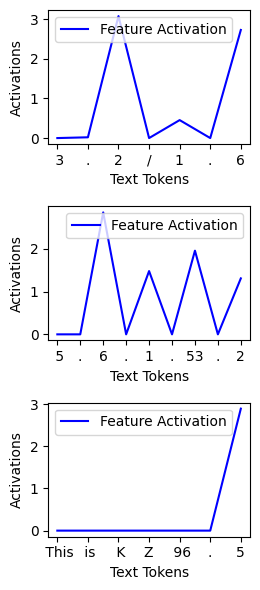

In [15]:
custom_text = [
    " 3.2/1.6",
    " 5.6.1.53.2",
    " This is KZ 96.5"
]
# visualize_text(custom_text, best_feature, model)
act_list, text_display_list = visualize_text(custom_text, best_feature, model, return_activations=True)
ablated_act_list, _ = ablate_text(custom_text, best_feature, model, return_activations=True)
act_list = act_list.squeeze().squeeze()
ablated_act_list = ablated_act_list.squeeze().squeeze()
# Find indices of "\n" in text_list
split_indices = [i for i, text in enumerate(text_display_list) if text == "\n"]

# Split text_list based on indices of "\n"
split_text_lists = [text_display_list[i:j] for i, j in zip([0]+[idx+1 for idx in split_indices], split_indices+[None])][:-1]

# Similarly, split act_list. Since there's a one-to-one correspondence between text_list and act_list
split_act_lists = [act_list[i:j] for i, j in zip([0]+[idx+1 for idx in split_indices], split_indices+[None])][:-1]

split_ablated_act_lists = [ablated_act_list[i:j] for i, j in zip([0]+[idx+1 for idx in split_indices], split_indices+[None])][:-1]

#Save split_text/act/ablated
import pickle
with open(f"images/feature_activation_and_ablated_{best_feature}.pkl", "wb") as f:
    pickle.dump((split_text_lists, split_act_lists, split_ablated_act_lists), f)
import matplotlib.pyplot as plt
invisible_char = '\u200B'

nrows = len(split_text_lists)
fig, axes = plt.subplots(nrows=nrows, figsize=(3, 2*nrows))
# Iterate through both split lists and plot them
for text_ind in range(nrows):
# for text_seq, act_seq in zip(split_text_lists, split_act_lists):
    ax = axes[text_ind]
    text_seq = split_text_lists[text_ind]
    act_seq = split_act_lists[text_ind]
    # ablated_act_seq = split_ablated_act_lists[text_ind]
    # Modify the text_seq to add the invisible character
    modified_text_seq = [text + invisible_char*i for i, text in enumerate(text_seq)]
    # plt.figure(figsize=(3, 3))  # Create a new figure for each text sequence
    # Color is blue and labeled "activation"
    ax.plot(modified_text_seq, act_seq, color='b', label='Feature Activation')
    # ax.plot(modified_text_seq, ablated_act_seq, color='r', label='Ablated Activation-diff of last token')
    ax.legend()  # Show the legend
    ax.set_xlabel("Text Tokens")
    ax.set_ylabel("Activations")

# Adjust layout for better display
plt.tight_layout()
plt.subplots_adjust(right=0.85) 
plt.show()

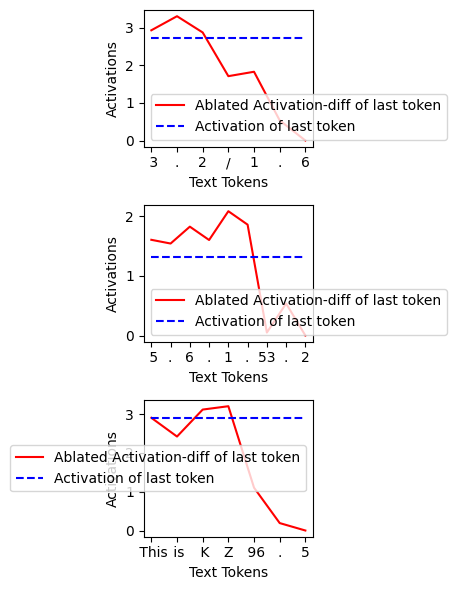

In [13]:
nrows = len(split_text_lists)
fig, axes = plt.subplots(nrows=nrows, figsize=(3, 2*nrows))
last_token_activation = [act_list[-1] for act_list in split_act_lists]
for text_ind in range(nrows):
# for text_seq, act_seq in zip(split_text_lists, split_act_lists):
    ax = axes[text_ind]
    text_seq = split_text_lists[text_ind]
    ablated_act_seq = split_ablated_act_lists[text_ind]
    # Modify the text_seq to add the invisible character
    modified_text_seq = [text + invisible_char*i for i, text in enumerate(text_seq)]
    last_token_act = last_token_activation[text_ind] 
    ablated_act_seq += last_token_act
    ax.plot(modified_text_seq, ablated_act_seq, color='r', label='Ablated Activation-diff of last token')

    # Plot a blue, dotted line to show the activation of the last token
    # ax.plot(modified_text_seq, [0, last_token_act], color='b', linestyle='--', label='Activation of last token')
    ax.plot(modified_text_seq, [last_token_act]*len(modified_text_seq), color='b', linestyle='--', label='Activation of last token')
    ax.legend()  # Show the legend
    ax.set_xlabel("Text Tokens")
    ax.set_ylabel("Activations")

# Adjust layout for better display
plt.tight_layout()
plt.subplots_adjust(right=0.85) 
plt.show()

In [169]:
plt.show()

In [57]:
ablate_feature_direction_display(full_text, best_feature)

In [65]:
logit_lens(model,best_feature, smaller_dict, layer)

[' ports', ' coff', ' manufact', ' quarters', ' revenues', ' commerce', ' revenue', ' =>', ' tires', ' appealed', ' quarter', ' nombre', ' addressed', 'ftware', ' parity', ' port', ' Rab', ' notwithstanding', ' tract', ' humour']
tensor([1.0664, 1.0092, 0.8916, 0.8852, 0.8766, 0.8653, 0.8618, 0.8567, 0.8510,
        0.8441, 0.8361, 0.8341, 0.8334, 0.8325, 0.8312, 0.8150, 0.8143, 0.8104,
        0.8097, 0.8046])


In [139]:
custom_text = [
    " 3.2/1.6",
    " Section 5.6.1",
    " This is KZ 96.5"
]
visualize_text(custom_text, best_feature, model)

# Data Centric Viewpoint

In [ ]:
# Go through datapoints & see if the features that activate on them make sense.
d_point = 0
# text = tokens_dataset[d_point]
data_ind, sequence_pos = np.unravel_index(d_point, (datapoints, token_amount))
feature_val, feature_ind = dictionary_activations[d_point].topk(10)
data_ind = int(data_ind)
sequence_pos = int(sequence_pos)
full_tok = torch.tensor(dataset[data_ind]["input_ids"])
full_text = []
full_text.append(model.tokenizer.decode(full_tok))
visualize_text(full_text, feature_ind, model)

# Check the neuron/residual basis
When we look at the weights of a feature, we are seeing the literal dimensions from the residual stream/neurons being read from the feature. 

Here I'm visualizing the weight values for the residual stream. If there are outliers, then it's mainly reading from that dimension.

In [ ]:
(weights*max_activation).topk(20), (weights*max_activation).topk(20, largest=False).values, (weights*max_activation > 0.2).sum()

# Prepend/Append tokens
We can iterate over all tokens to check which ones activate a feature a lot to more rigorously test a hypothesis on what a feature means.

Note: I'm literately running the model through all 50k tokens prepended to the text here

In [ ]:
def prepend_all_tokens_and_get_feature_activation(model, minimal_activating_example, feature, setting="prepend"):
    tokens = model.to_tokens(minimal_activating_example, prepend_bos=False)

    # Run through every number up to vocab size
    vocab_size = model.cfg.d_vocab
    batch_size = 256*2 # Define your desired batch size

    dollar_feature_activations = torch.zeros(vocab_size)
    for start in range(0, vocab_size, batch_size):
        end = min(start + batch_size, vocab_size)

        token_prep = torch.arange(start, end).to(device)
        token_prep = token_prep.unsqueeze(1)  # Add a dimension for concatenation

        # 1. Prepend to the tokens
        if setting == "prepend":
            tokens_catted = torch.cat((token_prep, tokens.repeat(end - start, 1)), dim=1).long()
        elif setting == "append":
            tokens_catted = torch.cat((tokens.repeat(end - start, 1), token_prep), dim=1).long()
        else:
            raise ValueError(f"Unknown setting: {setting}")

        # 2. Run through the model
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens_catted.to(device))
            neuron_act_batch = cache[cache_name]
            _, act = smaller_auto_encoder(neuron_act_batch)

        # 3. Get the feature
        dollar_feature_activations[start:end] = act[:, -1, feature].cpu().squeeze()

    k = 20
    k_increasing_val, k_increasing_ind = dollar_feature_activations.topk(k)
    k_decreasing_val, k_decreasing_ind = dollar_feature_activations.topk(k, largest=False)
    if(setting == "prepend"):
        print(f"[token]{minimal_activating_example}")
    elif(setting == "append"):
        print(f"{minimal_activating_example}[token]")
    else:
        raise ValueError(f"Unknown setting: {setting}")
    # Print indices converted to tokens
    print(f"Top-{k} increasing: {model.to_str_tokens(k_increasing_ind)}")
    # Print values
    print(f"Top-{k} increasing: {[f'{val:.2f}' for val in k_increasing_val]}")
    print(f"Top-{k} decreasing: {model.to_str_tokens(k_decreasing_ind)}")
    print(f"Top-{k} decreasing: {[f'{val:.2f}' for val in k_decreasing_val]}")
    print(f"Number of 0 activations: {torch.sum(dollar_feature_activations == 0)}")
    if(setting == "prepend"):
        best_text = "".join(model.to_str_tokens(dollar_feature_activations.argmax()) + [minimal_activating_example])
    else:
        best_text = "".join([minimal_activating_example] + model.to_str_tokens(dollar_feature_activations.argmax()))
    return best_text

best_text = ""
for x in range(3):
    # best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

In [ ]:
best_text = ""
for x in range(3):
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")

In [ ]:
prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, "The", best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")